In [5]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob, os
import numpy as np
from comet_ml import Experiment, Optimizer
import pickle

In [108]:
os.environ['TF_KERAS'] = '1'
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, CuDNNLSTM, Bidirectional, Input, concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import tensorflow as tf

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# only reserve 1 GPU

In [8]:
# tf.enable_eager_execution()

# Read data

In [9]:
def read_subject_writings(subject_file):
    writings = []
    with open(subject_file) as sf:
        contents = sf.read()
        root = ET.fromstring(contents)
        try:
            subject = root.findall('ID')[0].text.strip()
        except Exception:
            print('Cannot extract ID', contents[:500], '\n-------\n')        
        for w in root.iter('WRITING'):
            subject_writings = {'subject': subject}
            for title in w.findall('TITLE'):
                subject_writings['title'] = title.text
            for text in w.findall('TEXT'):
                subject_writings['text'] = text.text
            for date in w.findall('DATE'):
                subject_writings['date'] = date.text
            writings.append(subject_writings)
    return writings

In [40]:
# root_dir = '/home/bighanem/ana_data/' 
root_dir = '/home/ana/'

### eRisk 2020 T1

In [41]:
datadir_T1 = root_dir + '/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/data/'
labels_file_T1 = root_dir + '/eRisk/data//eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/golden_truth.txt'

In [14]:
def read_texts_2020(datadir_T1, labels_file_T1):
    writings = []
    for subject_file in os.listdir(datadir_T1):
        print(subject_file)
        writings.extend(read_subject_writings(os.path.join(datadir_T1, subject_file)))
    writings_df = pd.DataFrame(writings)

    labels_T1 = pd.read_csv(labels_file_T1, delimiter=' ', names=['subject', 'label'])
    labels_T1 = labels_T1.set_index('subject')

    writings_df['label'] = writings_df['subject'].apply(
    lambda s: labels_T1.loc[s, 'label'])
    
    return writings_df



### eRisk 2019 T1 (Anorexia)

In [42]:
datadirs_T1_2019 = {
    'train': ['2018 test/', '2018 train/positive_examples/', '2018 train/negative_examples/'],
    'test': ['data/']
}
datadir_root_T1_2019 = {
    'train': root_dir + '/eRisk/data/past/eRisk2019_T1/training data - t1/',
    'test': root_dir + '/eRisk/data/past/eRisk2019_T1/test data - T1/'
}
    
labels_files_T1_2019 = {
    'train': ['2018 train/risk_golden_truth.txt', '2018 test/risk-golden-truth-test.txt'],
    'test': ['T1_erisk_golden_truth.txt']
}

In [16]:
def read_texts_2019(datadir_root_T1_2019,
                   datadirs_T1_2019,
                   labels_files_T1_2019,
                   test_suffix='0000'):
    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()

    for subset in ('train', 'test'):
        for subdir in [os.path.join(datadir_root_T1_2019[subset], subp) for subp in datadirs_T1_2019[subset]]:
            if subset=='train':
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir, chunkdir) 
                             for chunkdir in os.listdir(subdir)]
            else:
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir)]
                
            for chunkdir in chunkdirs:
                if not os.path.isdir(chunkdir):
                    continue
                for subject_file in os.listdir(chunkdir):
                    writings[subset].extend(read_subject_writings(os.path.join(chunkdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        # add a suffix for users in the test -- the numbers are duplicated with the ones in train
        if subset=='test':
            writings_df_part['subject'] = writings_df_part['subject'].apply(lambda s: s+test_suffix)
            print(subset, writings_df_part.subject)
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

        for label_file in labels_files_T1_2019[subset]:
            labels = pd.read_csv(os.path.join(datadir_root_T1_2019[subset], label_file), 
                                 delimiter='\s+', names=['subject', 'label'])
            # add a suffix for users in the test -- the numbers are duplicated with the ones in train
            if subset=='test':
                labels['subject'] = labels['subject'].apply(lambda s: s+test_suffix)
            labels_df = pd.concat([labels_df, labels])
    labels_df = labels_df.drop_duplicates()
    labels_df = labels_df.set_index('subject')

    writings_df = writings_df.drop_duplicates()
    
    writings_df = writings_df.join(labels_df, on='subject')
    
    return writings_df

## Preprocess text

In [43]:
writings_df = read_texts_2020(datadir_T1, labels_file_T1)
# writings_df = read_texts_2019(datadir_root_T1_2019,
#                    datadirs_T1_2019,
#                    labels_files_T1_2019)
# writings_df = pickle.load(open('writings_df_liwc3', 'rb'))

subject8292.xml
subject6644.xml
subject7982.xml
subject9260.xml
subject9918.xml
subject4284.xml
subject9829.xml
subject7661.xml
subject8361.xml
subject4831.xml
subject2181.xml
subject9077.xml
subject2922.xml
subject2238.xml
subject4513.xml
subject269.xml
subject2678.xml
subject9197.xml
subject4143.xml
subject2605.xml
subject4226.xml
subject7627.xml
subject5150.xml
subject4510.xml
subject2182.xml
subject280.xml
subject1105.xml
subject187.xml
subject8001.xml
subject9285.xml
subject2621.xml
subject4414.xml
subject2685.xml
subject9961.xml
subject8065.xml
subject8225.xml
subject6866.xml
subject9949.xml
subject1507.xml
subject8329.xml
subject9411.xml
subject7857.xml
subject1545.xml
subject9811.xml
subject5000.xml
subject4843.xml
subject569.xml
subject51.xml
subject9156.xml
subject6453.xml
subject1210.xml
subject5528.xml
subject1485.xml
subject5935.xml
subject4527.xml
subject3301.xml
subject4074.xml
subject6093.xml
subject2088.xml
subject8990.xml
subject6459.xml
subject7830.xml
subject8395.xm

In [44]:
# writings_df[writings_df['subset']=='test']

In [46]:
writings_df[writings_df['text'].isna()][~writings_df['title'].isna()]

/home/ana/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,subject,title,date,text,label
0,subject8292,If anyone could help with which sub to put thi...,2016-08-02 09:22:12,NaN,0
1,subject8292,I'm literally never gonna stop waiting...,2016-08-05 09:35:55,NaN,0
2,subject8292,This is a really interesting study! Makes sens...,2016-08-05 21:36:24,NaN,0
4,subject8292,Mostly always me during this whole charade,2016-08-09 08:39:41,NaN,0
7,subject8292,"What is your best advice to a healthy, success...",2016-11-02 05:33:33,NaN,0
...,...,...,...,...,...
170664,subject217,scary,2018-06-24 14:26:01,NaN,0
170668,subject217,rescuing man after his car got stuck on Rub' a...,2018-07-05 15:31:29,NaN,0
170680,subject217,"Gorilla in streets of Riyadh,KSA",2018-07-24 22:22:48,NaN,0
170681,subject217,"Gorilla in streets of Riyadh,KSA",2018-07-24 22:46:11,NaN,0


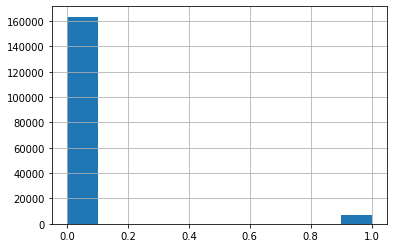

In [47]:
writings_df.label.hist()

In [48]:
writings_df

,subject,title,date,text,label
0,subject8292,If anyone could help with which sub to put thi...,2016-08-02 09:22:12,NaN,0
1,subject8292,I'm literally never gonna stop waiting...,2016-08-05 09:35:55,NaN,0
2,subject8292,This is a really interesting study! Makes sens...,2016-08-05 21:36:24,NaN,0
3,subject8292,The only thing Frank is building ...,2016-08-07 23:35:23,"... Is hype. Think about it, every time he wor...",0
4,subject8292,Mostly always me during this whole charade,2016-08-09 08:39:41,NaN,0
...,...,...,...,...,...
170693,subject217,NaN,2018-08-19 11:29:21,"this is my personal experience ,it may not ref...",0
170694,subject217,NaN,2018-08-19 16:17:34,stop looking at 20 million saudis as one entit...,0
170695,subject217,NaN,2018-08-19 20:00:31,i am aware of stats now and then. i was just s...,0
170696,subject217,WHAT DID YOU SAY TO ME?,2018-08-20 10:54:11,NaN,0


In [49]:
tokenizer = RegexpTokenizer(r'\w+')

def tokenize(t):
    return tokenizer.tokenize(t.lower())

In [50]:
tokenize("I wasn't ready to leave! buh-buw(dd). Sasa .")

['i', 'wasn', 't', 'ready', 'to', 'leave', 'buh', 'buw', 'dd', 'sasa']

In [51]:
writings_df['tokenized_title'] = writings_df['title'].apply(lambda t: tokenize(t) if type(t)==str and t else None)
writings_df['title_len'] = writings_df['tokenized_title'].apply(lambda t: len(t) if type(t)==list and t else None)
writings_df['tokenized_text'] = writings_df['text'].apply(lambda t: tokenize(t) if type(t)==str and t else None)
writings_df['text_len'] = writings_df['tokenized_text'].apply(lambda t: len(t) if type(t)==list and t else None)

In [52]:
writings_df.text_len.describe()

count    127604.00000
mean         32.35415
std          82.68303
min           1.00000
25%           6.00000
50%          13.00000
75%          31.00000
max        7201.00000
Name: text_len, dtype: float64

In [53]:
writings_df.title_len.describe()

count    49752.000000
mean        10.701922
std          9.282147
min          1.000000
25%          4.000000
50%          8.000000
75%         14.000000
max        149.000000
Name: title_len, dtype: float64

In [54]:
writings_df.groupby('subject').mean()

,label,title_len,text_len
subject,,,
subject0,0,20.285714,31.711712
subject1027,0,7.769231,1.190476
subject1055,0,16.666667,79.983193
subject1064,1,13.000000,68.410256
subject1089,0,9.823529,13.254902
...,...,...,...
subject9917,1,8.983607,95.806897
subject9918,0,5.000000,11.900901
subject992,0,5.872928,19.914122


In [55]:
writings_df.groupby('subject').max().groupby('label').count()

,date,title_len,text_len
label,,,
0,299,296,299
1,41,40,41


In [56]:
print("Average number of posts per user", writings_df.groupby('subject').count().title.mean())
print("Average number of comments per user", writings_df.groupby('subject').count().text.mean())


Average number of posts per user 146.35882352941175
Average number of comments per user 376.2970588235294


In [57]:
writings_df[(~writings_df['text_len'].isnull()) & (writings_df['text_len'] > 100)]


,subject,title,date,text,label,tokenized_title,title_len,tokenized_text,text_len
122,subject8292,Okay friends so I messed up and posted to do a...,2017-04-25 22:37:57,"Sorry for that, I truly didn't think it was go...",0,"[okay, friends, so, i, messed, up, and, posted...",34.0,"[sorry, for, that, i, truly, didn, t, think, i...",120.0
390,subject8292,NaN,2017-09-16 06:29:13,You've got plenty of time to fix that. You can...,0,None,NaN,"[you, ve, got, plenty, of, time, to, fix, that...",104.0
498,subject8292,NaN,2017-11-24 01:33:22,"LCD, Glass animals, Kendrick, The Weeknd, Jack...",0,None,NaN,"[lcd, glass, animals, kendrick, the, weeknd, j...",127.0
752,subject8292,Getting that coachella bod,2018-01-09 00:54:06,First I want to say whatever skin is your skin...,0,"[getting, that, coachella, bod]",4.0,"[first, i, want, to, say, whatever, skin, is, ...",149.0
904,subject8292,NaN,2018-03-12 17:14:03,Not the same but me and my wife saw a man and ...,0,None,NaN,"[not, the, same, but, me, and, my, wife, saw, ...",151.0
...,...,...,...,...,...,...,...,...,...
170652,subject217,NaN,2018-05-28 12:23:00,/r/keto /r/ketorecipes /r/ketodessert all are ...,0,None,NaN,"[r, keto, r, ketorecipes, r, ketodessert, all,...",197.0
170653,subject217,NaN,2018-05-28 12:32:36,its okay dont worry . as long as you don't exc...,0,None,NaN,"[its, okay, dont, worry, as, long, as, you, do...",109.0
170662,subject217,NaN,2018-06-20 00:33:57,the national number is :1919 here are more com...,0,None,NaN,"[the, national, number, is, 1919, here, are, m...",115.0
170693,subject217,NaN,2018-08-19 11:29:21,"this is my personal experience ,it may not ref...",0,None,NaN,"[this, is, my, personal, experience, it, may, ...",153.0


# Recurrent NN

## Extract features and encode data

In [58]:
hyperparams_features = {
    "max_features": 20000,
    # cut texts after this number of words
    # (among top max_features most common words)
    "maxlen": 100,
    "embedding_dim": 100,
    "user_level": True,
}


### Emotions

In [59]:
def load_NRC(nrc_path):
    word_emotions = {}
    emotion_words = {}
    with open(nrc_path) as in_f:
        for line in in_f:
            line = line.strip()
            if not line:
                continue
            word, emotion, label = line.split()
            if word not in word_emotions:
                word_emotions[word] = set()
            if emotion not in emotion_words:
                emotion_words[emotion] = set()
            label = int(label)
            if label:
                word_emotions[word].add(emotion)
                emotion_words[emotion].add(word)
    return emotion_words

nrc_lexicon_path = root_dir + '/resources/NRC-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_lexicon = load_NRC(nrc_lexicon_path)
emotions = list(nrc_lexicon.keys())


In [60]:
def encode_emotions(tokens, emotion_lexicon, emotions, relative=True):
    text_len = len(tokens)
    encoded_emotions = [0 for e in emotions]
    for i, emotion in enumerate(emotions):
        try:
            emotion_words = [t for t in tokens if t in emotion_lexicon[emotion]]
            if relative:
                encoded_emotions[i] = len(emotion_words) / len(tokens)
            else:
                encoded_emotions[i] = len(emotion_words)
        except ValueError:
            print("Emotion not found.")
    return encoded_emotions

In [61]:
from liwc_readDict import readDict

liwc = readDict(root_dir + '/resources/liwc.dic')

categories = set([c for (w,c) in liwc])
len(categories)

64

### Style features

#### Char n-grams

In [62]:
def extract_ngrams(tokens):
    pass

#### Personal pronouns

In [63]:
first_person_pronouns = {"i", "me", "my", "mine", "myself"}
def encode_pronouns(tokens, pronouns={"i", "me", "my", "mine", "myself"}, relative=True):
    if not tokens:
        return np.nan
    text_len = len(tokens)
    nr_pronouns = len([t for t in tokens if t in pronouns])
    if relative:
        return nr_pronouns/text_len
    else:
        return nr_pronouns

#### Stopwords

In [64]:
stopword_list = stopwords.words("english")
def encode_stopwords(tokens, stopwords=stopword_list):
    encoded_stopwords = [0 for s in stopword_list]
    if not tokens:
        return encoded_stopwords
    for i, stopword in enumerate(stopwords):
        if stopword in tokens:
            encoded_stopwords[i] += 1
    return encoded_stopwords

### Topics

### Encode data

In [70]:
from collections import Counter
def load_erisk_data(writings_df, voc_size, emotion_lexicon, seq_len, emotions =  
                    ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                     'negative', 'positive', 'sadness', 'surprise', 'trust'],
                    liwc_categories = categories,
                    pronouns = ["i", "me", "my", "mine", "myself"],
                    train_prop=0.7, valid_prop=0.3, min_post_len=3, min_word_len=1, 
                    user_level=True, vocabulary=None):
    print("Loading data...")
    if not vocabulary:
        vocabulary = {}
        word_freqs = Counter()
        for words in writings_df.tokenized_text:
            word_freqs.update(words)
        for words in writings_df.tokenized_title:
            word_freqs.update(words)
        i = 1
        for w, f in word_freqs.most_common(voc_size-2): # keeping voc_size-1 for unk
            if len(w) < min_word_len:
                continue
            vocabulary[w] = i
            i += 1
    tokens_data_train = []
    categ_data_train = []
    sparse_data_train = []
    tokens_data_valid = []
    categ_data_valid = []
    sparse_data_valid = []
    tokens_data_test = []
    categ_data_test = []
    sparse_data_test = []
    labels_train = []
    users_train = []
    labels_valid = []
    users_valid = []
    users_test = []
    labels_test = []
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        training_subjects = all_subjects[:training_subjects_size]
        test_subjects = all_subjects[training_subjects_size:]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    categories = [c for c in liwc_categories if c in writings_df.columns]
    print(len(training_subjects), "training users, ", 
          len(valid_subjects), "validation users, ",
          len(test_subjects), " test users.")
#     training_rows = writings_df[writings_df['subject'].isin(training_subjects)].sample(frac=1) # shuffling
#     test_rows = writings_df[~writings_df['subject'].isin(training_subjects)].sample(frac=1)
#     positive_training_users = training_rows.groupby('subject').max().groupby('label').count().date[1]
#     positive_test_users = test_rows.groupby('subject').max().groupby('label').count().date[1]
#     print("Positive training users: ", positive_training_users, ", positive test users: ", positive_test_users)
    def encode_text(tokens):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [vocabulary.get(w, voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, emotion_lexicon, emotions)
        encoded_pronouns = encode_pronouns(tokens, pronouns)
        encoded_stopwords = encode_stopwords(tokens)
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords)
    user_level_texts = {}
    for row in writings_df.itertuples():
        words = []
        if row.tokenized_title:
            words.extend(row.tokenized_title)
        if row.tokenized_text:
            words.extend(row.tokenized_text)
        if not words or len(words)<min_post_len:
            continue
        label = row.label
        liwc_categs = [getattr(row, categ) for categ in categories]
        if row.subject not in user_level_texts.keys():
            user_level_texts[row.subject] = {}
            user_level_texts[row.subject]['texts'] = [words]
            user_level_texts[row.subject]['label'] = label
            user_level_texts[row.subject]['liwc'] = [liwc_categs]
        else:
            user_level_texts[row.subject]['texts'].append(words) # TODO: sort datapoints chronologically
            user_level_texts[row.subject]['liwc'].append(liwc_categs)

    for subject in user_level_texts.keys():
        texts = user_level_texts[subject]['texts']
        label = user_level_texts[subject]['label']
        if user_level:
            all_words = [sum(texts, [])] # merge all texts in one list
            liwc_aggreg = [np.array(user_level_texts[subject]['liwc']).mean(axis=0).tolist()]
        else:
            all_words = texts
            liwc_aggreg = user_level_texts[subject]['liwc']
        for i, words in enumerate(all_words):
            encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords = encode_text(words)
            subject_id = int(subject.split('t')[1])
            if subject in training_subjects:
                tokens_data_train.append(encoded_tokens)
                categ_data_train.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
                sparse_data_train.append(encoded_stopwords)
                labels_train.append(label)
                users_train.append(subject_id)
            elif subject in valid_subjects:
                tokens_data_valid.append(encoded_tokens)
                categ_data_valid.append(encoded_emotions + [encoded_pronouns]  + liwc_aggreg[i])
                sparse_data_valid.append(encoded_stopwords)
                labels_valid.append(label)
                users_valid.append(subject_id)
            else:
                tokens_data_test.append(encoded_tokens)
                categ_data_test.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
                sparse_data_test.append(encoded_stopwords)
                labels_test.append(label)
                users_test.append(subject_id)
        
    # using zeros for padding
    tokens_data_train_padded = sequence.pad_sequences(tokens_data_train, maxlen=seq_len)
    tokens_data_valid_padded = sequence.pad_sequences(tokens_data_valid, maxlen=seq_len)
    tokens_data_test_padded = sequence.pad_sequences(tokens_data_test, maxlen=seq_len)
        
    return ([np.array(tokens_data_train_padded), np.array(categ_data_train), np.array(sparse_data_train),
            np.array(users_train)],
            np.array(labels_train)), \
            ([np.array(tokens_data_valid_padded), np.array(categ_data_valid), np.array(sparse_data_valid),
            np.array(users_valid)],
            np.array(labels_valid)), \
            ([np.array(tokens_data_test_padded), np.array(categ_data_test), np.array(sparse_data_test),
             np.array(users_test)],
             np.array(labels_test)), vocabulary

In [71]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(writings_df, 
                                                            seq_len=hyperparams_features['maxlen'],
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
#                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
                                                                               )

Loading data...
166 training users,  71 validation users,  103  test users.


In [72]:
x_train_seq, x_train_categ, x_train_sparse, x_train_users = x_train
x_valid_seq, x_valid_categ, x_valid_sparse, x_valid_users = x_valid
x_test_seq, x_test_categ, x_test_sparse, x_test_users = x_test
print(len(x_train_seq), 'train sequences')
print(len(x_valid_seq), 'train sequences')
print(len(x_test_seq), 'test sequences')

166 train sequences
71 train sequences
103 test sequences


In [73]:
print(pd.Series(y_train).sum(), "positive training examples")
print(pd.Series(y_valid).sum(), "positive validation examples")

print(pd.Series(y_test).sum(), "positive test examples")

19 positive training examples
5 positive validation examples
17 positive test examples


In [74]:
x_train

[array([[ 5537,   185,     7, ...,    64,    11, 11012],
        [    2,   121,     4, ...,  1495,   436, 19999],
        [  250,     3,    89, ..., 19999,   829,   207],
        ...,
        [   27,    32,    21, ...,   240,  1425,  2193],
        [  230,     7,     8, ...,     3,   340,    10],
        [    2,    32,    15, ...,     4,   324, 19999]], dtype=int32),
 array([[0.01368948, 0.02103506, 0.00834725, ..., 0.01068447, 0.02838063,
         0.02337229],
        [0.01486989, 0.04089219, 0.01115242, ..., 0.01115242, 0.04460967,
         0.05576208],
        [0.01768878, 0.02106219, 0.01037972, ..., 0.01851051, 0.0350532 ,
         0.01448837],
        ...,
        [0.01091779, 0.019756  , 0.00713989, ..., 0.00849161, 0.02526688,
         0.05580202],
        [0.01725149, 0.01764255, 0.00809181, ..., 0.00976131, 0.0382932 ,
         0.00753531],
        [0.01476301, 0.02797203, 0.01087801, ..., 0.01709402, 0.03807304,
         0.05749806]]),
 array([[1, 1, 1, ..., 0, 0, 0],
      

In [75]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([0.56462585, 4.36842105])

In [77]:
def load_embeddings(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+2, embedding_dim)) - 0.5 # voc + unk + pad value(0)
#     embedding_matrix = np.zeros((len(voc)+1, embedding_dim))

    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
    f.close()

    print('Total %s word vectors.' % len(embedding_matrix))

 
    return embedding_matrix

# pretrained_embeddings_path = '/home/ana/resources/glove.6B/glove.6B.%dd.txt' % hyperparams_features['embedding_dim']
pretrained_embeddings_path = root_dir + '/resources/glove.twitter.27B/glove.twitter.27B.%dd.txt' % hyperparams_features['embedding_dim']
embedding_matrix = load_embeddings(pretrained_embeddings_path, hyperparams_features['embedding_dim'], voc)


Total 20000 word vectors.


In [78]:
x_train[2].shape

(166, 179)

## Define model

In [79]:
hyperparams = {
    'lstm_units': 100,
    'dense_bow_units': 5,
    'dropout': 0.14,
    'l2_dense': 0.00011,
    'l2_embeddings': 0.00001,
    'optimizer': 'adam',
    'decay': 0.0001,
    'lr': 0.001,
    "batch_size": 32,
    "trainable_embeddings": False,
    "reduce_lr_factor": 0.02,
    "reduce_lr_patience": 50,
    "freeze_patience": 50,
    'threshold': 0.5,


}
if not hyperparams['optimizer']:
    hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                   decay=hyperparams['decay'])

In [83]:
class Metrics():
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def recall_m(self, y_true, y_pred):
            y_labels = y_true#tf.reshape(y_true[:], (-1,1))
    #         y_pred = tf.reshape(y_pred, (-1,1))
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            possible_positives = K.sum(K.round(K.clip(y_labels, 0, 1)))
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

    def precision_m(self, y_true, y_pred):
            y_labels = y_true#tf.reshape(y_true[:], (-1,1))
    #         y_pred = tf.reshape(y_pred, (-1,1))
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

    def f1_m(self, y_true, y_pred):
        precision = self.precision_m(y_true, y_pred)
        recall = self.recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

def binary_crossentropy_custom(y_true, y_pred):
    y_labels = y_true#tf.reshape(y_true[0],(1,-1))
    return K.binary_crossentropy(y_labels, 
                                 y_pred)

In [111]:
def build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[]):

    tokens_features = Input(shape=(hyperparams_features['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams_features['maxlen'],
                                mask_zero=True,
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)
#     lstm_layers = Bidirectional(LSTM(hyperparams['lstm_units']))(embedding_layer)
    lstm_layers = CuDNNLSTM(hyperparams['lstm_units'], 
#                             dropout=hyperparams['dropout'],
#                       recurrent_dropout=hyperparams['dropout'],
                      name='LSTM_layer')(embedding_layer)
    dropout_layer = Dropout(hyperparams['dropout'], name='lstm_wdropout')(lstm_layers)
    numerical_features = Input(shape=(len(emotions) + 1 + len(liwc_categories),), name='numeric_input') # emotions and pronouns
    dense_layer = Dense(units=1,
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                        name='numerical_dense_layer',
                       )(numerical_features)
    sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input') # stopwords
    subjects = Input(shape=(1,), name='subjects')
    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              )(sparse_features)
#     # TODO: this is getting out of hand. Refactor this ablation part.
    all_layers = {
        'lstm_layers': dropout_layer,
        'numerical_dense_layer': numerical_features,# dense_layer,
        'sparse_feat_dense_layer': sparse_features#dense_layer_sparse,
    }
    layers_to_merge = []
    for n, l in all_layers.items():
        if n in ignore_layer:
            continue
        layers_to_merge.append(l)
        
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
    output_layer = Dense(1, activation='sigmoid',
                         name='output_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']))(merged_layers)

    # Compile model
    model = Model(inputs=[tokens_features, numerical_features, sparse_features, subjects], 
                  outputs=output_layer)
    metrics_class = Metrics(threshold=hyperparams['threshold'])
    model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
    return model


In [112]:
model = build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
                    liwc_categories=[c for c in categories if c in writings_df.columns]
,
                   ignore_layer=['lstm_layers'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
numeric_input (InputLayer)      (None, 11)           0                                            
__________________________________________________________________________________________________
sparse_input (InputLayer)       (None, 179)          0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 190)          0           numeric_input[0][0]              
                                                                 sparse_input[0][0]               
__________________________________________________________________________________________________
output_layer (Dense)            (None, 1)            191         concatenate_3[0][0]              
Total para

In [113]:
plot_model(model, 'models/lstm_plus_ablated3.png')

In [114]:
experiment = Experiment(api_key="eoBdVyznAhfg3bK9pZ58ZSXfv",
                        project_name="mental", workspace="ananana")

experiment.log_parameters(hyperparams_features)

experiment.log_parameter('emotion_lexicon', nrc_lexicon_path)
experiment.log_parameter('emotions', emotions)
experiment.log_parameter('embeddings_path', pretrained_embeddings_path)

experiment.log_parameters(hyperparams)

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/ananana/mental/be350999b7a24760a3cfdad7240a257f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1_m [501]        : (0.0, 0.6666666269302368)
COMET INFO:     batch_loss [501]        : (0.31647342443466187, 0.9732389450073242)
COMET INFO:     batch_precision_m [501] : (0.0, 0.5)
COMET INFO:     batch_recall_m [501]    : (0.0, 1.0)
COMET INFO:     epoch_duration [501]    : (0.03274282399797812, 1.448123376001604)
COMET INFO:     f1_m [501]              : (0.0, 0.42467594146728516)
COMET INFO:     loss [501]              : (0.4481326693511871, 1.1047792305429298)
COMET INFO:     lr [501]                : (9.999999974752427e-07, 0.0010000000474974513)
COMET INFO:     precision_m [501]       : (0.0, 0.320507675409317)
COMET INFO:     recall_m [501]          : (0.0, 1.0)
COMET INFO:     step                    : 3006
COMET INFO:     s

In [115]:
voc

{'the': 1,
 'i': 2,
 'to': 3,
 'a': 4,
 'and': 5,
 'of': 6,
 'it': 7,
 'in': 8,
 'you': 9,
 'that': 10,
 'is': 11,
 's': 12,
 'for': 13,
 'this': 14,
 't': 15,
 'on': 16,
 'with': 17,
 'but': 18,
 'my': 19,
 '8217': 20,
 'be': 21,
 'was': 22,
 'have': 23,
 'are': 24,
 'not': 25,
 'they': 26,
 'as': 27,
 'if': 28,
 'so': 29,
 'just': 30,
 'what': 31,
 'can': 32,
 'like': 33,
 'he': 34,
 'or': 35,
 'at': 36,
 'we': 37,
 'me': 38,
 'from': 39,
 'your': 40,
 'm': 41,
 'do': 42,
 'com': 43,
 'all': 44,
 'about': 45,
 'an': 46,
 'one': 47,
 'there': 48,
 'would': 49,
 'out': 50,
 'up': 51,
 'when': 52,
 'more': 53,
 'get': 54,
 'don': 55,
 'people': 56,
 'by': 57,
 'will': 58,
 'no': 59,
 'how': 60,
 'https': 61,
 'gt': 62,
 'has': 63,
 'them': 64,
 'his': 65,
 'time': 66,
 'some': 67,
 're': 68,
 'know': 69,
 'think': 70,
 'who': 71,
 'their': 72,
 'because': 73,
 'had': 74,
 'she': 75,
 'here': 76,
 'good': 77,
 'really': 78,
 'www': 79,
 'r': 80,
 'now': 81,
 've': 82,
 'been': 83,
 'only

## Train

In [116]:
class WeightsHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.log_weights(0)

    def on_epoch_end(self, epoch, logs={}):
        self.log_weights(epoch)
        
    def log_weights(self, step):
        for layer_name in ['LSTM_layer', 'embeddings_layer', 'sparse_feat_dense_layer', 'output_layer']:
            try:
                layer = self.model.get_layer(layer_name)
                experiment.log_histogram_3d(layer.get_weights()[0], 
                                            name=layer_name,
                                   step=step)  
            except Exception as e:
                print("Logging weights", e)
                # layer probably does not exist
                pass
        
class FreezeLayer(callbacks.Callback):
    def __init__(self, logs={}, patience=5, layer='embeddings_layer', verbose=1, set_to=False):
        super(FreezeLayer, self).__init__()
        self.freeze_epoch = patience
        self.freeze_layer = layer
        self.verbose = verbose
        self.set_to = set_to

    def on_epoch_begin(self, epoch, logs={}):
        if epoch == self.freeze_epoch:
            try:
                layer = model.get_layer(self.freeze_layer)
                old_value = layer.trainable
                layer.trainable = self.set_to
                model.compile()
                if self.verbose:
                    print("Setting %s layer from %s to trainable=%s..." % (layer.name, old_value,
                                                                   model.get_layer(self.freeze_layer).trainable))
            except Exception as e:
                # layer probably does not exist
                pass

In [117]:
def train_model(model, 
                x_train, y_train, x_test, y_test, 
                batch_size, epochs, class_weight, start_epoch=0, workers=4,
                callback_list = [],
                model_path='/tmp/model'):
    print('Train...')
    experiment.log_parameter('class_weight', class_weight.values())
    experiment.log_parameter('callbacks', callbacks)

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, initial_epoch=start_epoch, 
              class_weight=class_weight,
              validation_data=[x_test, y_test],
#               validation_split=0.3,
                       workers=workers,
            callbacks = [
#                 callbacks.ModelCheckpoint(filepath='%s_best' % model_path, verbose=1, 
#                                           save_best_only=True, save_weights_only=True),
                callbacks.EarlyStopping(patience=500), *callback_list
            ])
    model.save(model_path)#, save_weights_only=True)
    experiment.log_parameter('model_path', model_path)
    return history

In [118]:
%%time

freeze_layer = FreezeLayer(hyperparams['freeze_patience'], set_to=not hyperparams['trainable_embeddings'])
weights_history = WeightsHistory()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=hyperparams['reduce_lr_factor'],
                          patience=hyperparams['reduce_lr_patience'], min_lr=0.000001, verbose=1)

history = train_model(model, x_train, y_train, x_valid, y_valid,
           epochs=1000, batch_size=hyperparams['batch_size'],
                      class_weight={0:0.5, 1:10}, start_epoch=0,
                      callback_list = [freeze_layer, weights_history, reduce_lr],
                      model_path='models/lstm_plus_ablated_user3', workers=4)

Train...
Train on 166 samples, validate on 71 samples
Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
Epoch 1/1000
 32/166 [====>.........................] - ETA: 2s - loss: 0.6045 - f1_m: 0.1818 - precision_m: 0.1000 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 1s 6ms/sample - loss: 0.6082 - f1_m: 0.2447 - precision_m: 0.1665 - recall_m: 0.9111 - val_loss: 1.0046 - val_f1_m: 0.1656 - val_precision_m: 0.0914 - val_recall_m: 1.0000
Epoch 2/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.5928 - f1_m: 0.2941 - precision_m: 0.1786 - recall_m: 0.8333Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [===================

 32/166 [====>.........................] - ETA: 0s - loss: 0.5040 - f1_m: 0.2000 - precision_m: 0.1111 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 361us/sample - loss: 0.5351 - f1_m: 0.3190 - precision_m: 0.1971 - recall_m: 1.0000 - val_loss: 0.7929 - val_f1_m: 0.0870 - val_precision_m: 0.0502 - val_recall_m: 0.5000
Epoch 18/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.5503 - f1_m: 0.3200 - precision_m: 0.1905 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 369us/sample - loss: 0.5322 - f1_m: 0.2418 - precision_m: 0.1420 - recall_m: 0.8333 - val_loss: 0.8362 - val_f1_m: 0.1017 - val_precision_m: 0.0575 - val_recall_m: 0.5833
Epoch 19/1000
 32/16

166/166 [==============================] - 0s 420us/sample - loss: 0.4936 - f1_m: 0.3286 - precision_m: 0.2110 - recall_m: 1.0000 - val_loss: 0.7610 - val_f1_m: 0.1587 - val_precision_m: 0.0948 - val_recall_m: 0.5000
Epoch 34/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.5120 - f1_m: 0.1818 - precision_m: 0.1000 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 358us/sample - loss: 0.4792 - f1_m: 0.3233 - precision_m: 0.1962 - recall_m: 1.0000 - val_loss: 0.7590 - val_f1_m: 0.2297 - val_precision_m: 0.1556 - val_recall_m: 0.5000
Epoch 35/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4527 - f1_m: 0.3200 - precision_m: 0.1905 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/16

 32/166 [====>.........................] - ETA: 0s - loss: 0.4227 - f1_m: 0.3478 - precision_m: 0.2105 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 403us/sample - loss: 0.4367 - f1_m: 0.3145 - precision_m: 0.1882 - recall_m: 1.0000 - val_loss: 0.8138 - val_f1_m: 0.1087 - val_precision_m: 0.0643 - val_recall_m: 0.3889
Epoch 51/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4952 - f1_m: 0.2308 - precision_m: 0.1304 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 389us/sample - loss: 0.4434 - f1_m: 0.3338 - precision_m: 0.2072 - recall_m: 1.0000 - val_loss: 0.8282 - val_f1_m: 0.0800 - val_precision_m: 0.0476 - val_recall_m: 0.2500
Epoch 52/1000
 32/16

Epoch 67/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4820 - f1_m: 0.2500 - precision_m: 0.1429 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 366us/sample - loss: 0.4288 - f1_m: 0.3307 - precision_m: 0.2327 - recall_m: 0.8929 - val_loss: 0.6628 - val_f1_m: 0.1429 - val_precision_m: 0.0907 - val_recall_m: 0.5556
Epoch 68/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4105 - f1_m: 0.3478 - precision_m: 0.2105 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 334us/sample - loss: 0.4368 - f1_m: 0.2737 - precision_m: 0.1766 - recall_m: 0.8125 - val_loss: 0.6827 - val_f1_m: 0.1345 - val_precision_m: 0.0828 - val_recall_m: 0.3889
Epoch 

166/166 [==============================] - 0s 383us/sample - loss: 0.4581 - f1_m: 0.4047 - precision_m: 0.2939 - recall_m: 0.7639 - val_loss: 0.6114 - val_f1_m: 0.2100 - val_precision_m: 0.1389 - val_recall_m: 0.6667
Epoch 84/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.3942 - f1_m: 0.2500 - precision_m: 0.1429 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 340us/sample - loss: 0.4228 - f1_m: 0.3000 - precision_m: 0.1931 - recall_m: 0.7583 - val_loss: 0.6188 - val_f1_m: 0.1241 - val_precision_m: 0.0741 - val_recall_m: 0.3889
Epoch 85/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.3259 - f1_m: 0.5833 - precision_m: 0.4118 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/16

 32/166 [====>.........................] - ETA: 0s - loss: 0.3697 - f1_m: 0.3333 - precision_m: 0.2000 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 423us/sample - loss: 0.3914 - f1_m: 0.3173 - precision_m: 0.2011 - recall_m: 0.7917 - val_loss: 0.6027 - val_f1_m: 0.1250 - val_precision_m: 0.0769 - val_recall_m: 0.3333
Epoch 101/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4162 - f1_m: 0.4286 - precision_m: 0.2727 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 326us/sample - loss: 0.3897 - f1_m: 0.3882 - precision_m: 0.2437 - recall_m: 0.9583 - val_loss: 0.5974 - val_f1_m: 0.1306 - val_precision_m: 0.0778 - val_recall_m: 0.5556
Epoch 102/1000
 32/

Epoch 117/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.3743 - f1_m: 0.3333 - precision_m: 0.2000 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 368us/sample - loss: 0.3749 - f1_m: 0.3552 - precision_m: 0.2239 - recall_m: 1.0000 - val_loss: 0.6381 - val_f1_m: 0.1000 - val_precision_m: 0.0588 - val_recall_m: 0.3333
Epoch 118/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.2918 - f1_m: 0.4706 - precision_m: 0.3077 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 365us/sample - loss: 0.3873 - f1_m: 0.2990 - precision_m: 0.1908 - recall_m: 0.8333 - val_loss: 0.6385 - val_f1_m: 0.1215 - val_precision_m: 0.0722 - val_recall_m: 0.5000
Epoc

Epoch 134/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.3013 - f1_m: 0.4762 - precision_m: 0.3125 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 359us/sample - loss: 0.3689 - f1_m: 0.4068 - precision_m: 0.2684 - recall_m: 1.0000 - val_loss: 0.6363 - val_f1_m: 0.2254 - val_precision_m: 0.1624 - val_recall_m: 0.6667
Epoch 135/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.3486 - f1_m: 0.4615 - precision_m: 0.3000 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 376us/sample - loss: 0.3841 - f1_m: 0.4128 - precision_m: 0.2769 - recall_m: 1.0000 - val_loss: 0.6363 - val_f1_m: 0.1254 - val_precision_m: 0.0754 - val_recall_m: 0.5000
Epoc

Epoch 151/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4423 - f1_m: 0.3478 - precision_m: 0.2105 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 383us/sample - loss: 0.3754 - f1_m: 0.4179 - precision_m: 0.2820 - recall_m: 1.0000 - val_loss: 0.6312 - val_f1_m: 0.0909 - val_precision_m: 0.0556 - val_recall_m: 0.2500
Epoch 152/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.3668 - f1_m: 0.2667 - precision_m: 0.1538 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 257us/sample - loss: 0.3674 - f1_m: 0.4218 - precision_m: 0.2878 - recall_m: 1.0000 - val_loss: 0.6315 - val_f1_m: 0.1000 - val_precision_m: 0.0625 - val_recall_m: 0.2500
Epoc

166/166 [==============================] - 0s 439us/sample - loss: 0.4260 - f1_m: 0.2942 - precision_m: 0.1951 - recall_m: 0.6667 - val_loss: 0.6339 - val_f1_m: 0.1345 - val_precision_m: 0.0778 - val_recall_m: 0.5000
Epoch 168/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.5474 - f1_m: 0.2000 - precision_m: 0.1111 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 317us/sample - loss: 0.4088 - f1_m: 0.2988 - precision_m: 0.2017 - recall_m: 0.8333 - val_loss: 0.6339 - val_f1_m: 0.3111 - val_precision_m: 0.2222 - val_recall_m: 0.5556
Epoch 169/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.3603 - f1_m: 0.4348 - precision_m: 0.2778 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/

Epoch 184/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4742 - f1_m: 0.1333 - precision_m: 0.0714 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 384us/sample - loss: 0.3934 - f1_m: 0.3795 - precision_m: 0.2532 - recall_m: 1.0000 - val_loss: 0.6338 - val_f1_m: 0.3333 - val_precision_m: 0.2333 - val_recall_m: 0.6667
Epoch 185/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4003 - f1_m: 0.2400 - precision_m: 0.1364 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 311us/sample - loss: 0.3948 - f1_m: 0.4546 - precision_m: 0.3462 - recall_m: 1.0000 - val_loss: 0.6338 - val_f1_m: 0.1254 - val_precision_m: 0.0754 - val_recall_m: 0.5000
Epoc

Epoch 201/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4410 - f1_m: 0.2667 - precision_m: 0.1538 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 355us/sample - loss: 0.3773 - f1_m: 0.3163 - precision_m: 0.2001 - recall_m: 0.8333 - val_loss: 0.6339 - val_f1_m: 0.1111 - val_precision_m: 0.0769 - val_recall_m: 0.2000
Epoch 202/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.3929 - f1_m: 0.3478 - precision_m: 0.2105 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 370us/sample - loss: 0.3664 - f1_m: 0.3882 - precision_m: 0.2466 - recall_m: 1.0000 - val_loss: 0.6338 - val_f1_m: 0.1306 - val_precision_m: 0.0778 - val_recall_m: 0.5556
Epoc

166/166 [==============================] - 0s 350us/sample - loss: 0.3788 - f1_m: 0.2882 - precision_m: 0.1826 - recall_m: 0.8333 - val_loss: 0.6338 - val_f1_m: 0.1397 - val_precision_m: 0.0862 - val_recall_m: 0.3889
Epoch 218/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.4888 - f1_m: 0.1111 - precision_m: 0.0588 - recall_m: 1.0000Logging weights No such layer: LSTM_layer
Logging weights No such layer: embeddings_layer
Logging weights No such layer: sparse_feat_dense_layer
166/166 [==============================] - 0s 384us/sample - loss: 0.3629 - f1_m: 0.3969 - precision_m: 0.2688 - recall_m: 1.0000 - val_loss: 0.6337 - val_f1_m: 0.1229 - val_precision_m: 0.0722 - val_recall_m: 0.4444
Epoch 219/1000
 32/166 [====>.........................] - ETA: 0s - loss: 0.5065 - f1_m: 0.3529 - precision_m: 0.2143 - recall_m: 1.0000

KeyboardInterrupt: 

In [96]:
len(x_train[2][1])

179

In [187]:
model.get_weights()

[array([[ 1.44971931e+00],
        [ 5.99275768e-01],
        [ 4.79707479e-01],
        [-1.02073348e+00],
        [ 7.06191480e-01],
        [-5.70192754e-01],
        [-6.15594923e-01],
        [-8.78930449e-01],
        [-3.44653964e+00],
        [-4.17300969e-01],
        [-3.47588360e-01],
        [ 4.52555120e-01],
        [ 3.45672297e+00],
        [-4.62037057e-01],
        [-2.84551525e+00],
        [-3.03839874e+00],
        [ 1.36626410e+00],
        [-1.01885557e+00],
        [-2.80554235e-01],
        [-1.33873188e+00],
        [ 6.81673288e-01],
        [-1.62495267e+00],
        [-5.50505295e+01],
        [-1.37413883e+00],
        [-1.92312765e+00],
        [ 6.35300815e-01],
        [ 1.14118254e+00],
        [-2.15535760e+00],
        [-2.97780067e-01],
        [-3.38145828e+00],
        [ 1.78429782e-01],
        [ 1.10952210e+00],
        [-1.82261813e+00],
        [ 1.32531798e+00],
        [-1.74499857e+00],
        [ 1.44931817e+00],
        [-7.66425788e-01],
 

In [107]:
plot_model(model, to_file='models/lstm_plus4.png')

In [161]:
dependencies = {
    'f1_m': f1_m,
    'precision_m': precision_m,
    'recall_m': recall_m,
    'binary_crossentropy_custom': binary_crossentropy_custom
}
model = load_model('models/lstm_plus8_remote', custom_objects=dependencies)

Labels Tensor("dense_1_target_1:0", shape=(?, ?), dtype=float32)
Predictions Tensor("Sigmoid_2:0", shape=(?, 1), dtype=float32)
True positives Tensor("metrics_1/f1_m/Sum_2:0", shape=(), dtype=float32)
Labels Tensor("dense_1_target_1:0", shape=(?, ?), dtype=float32)
Predictions Tensor("Sigmoid_2:0", shape=(?, 1), dtype=float32)
True positives Tensor("metrics_1/f1_m/Sum_7:0", shape=(), dtype=float32)
Labels Tensor("dense_1_target_1:0", shape=(?, ?), dtype=float32)
Predictions Tensor("Sigmoid_2:0", shape=(?, 1), dtype=float32)
True positives Tensor("metrics_1/recall_m/Sum:0", shape=(), dtype=float32)
Labels Tensor("dense_1_target_1:0", shape=(?, ?), dtype=float32)
Predictions Tensor("Sigmoid_2:0", shape=(?, 1), dtype=float32)
True positives Tensor("metrics_1/recall_m/Sum_3:0", shape=(), dtype=float32)


In [105]:
model.evaluate(x_test, y_test)

103/103 [==============================] - 0s 62us/sample - loss: 0.7235 - f1_m: 0.3611 - precision_m: 0.2788 - recall_m: 0.7054


[0.7234657777165904, 0.36112642, 0.2787594, 0.70535713]

### Feature importance

In [364]:
weights = model.get_weights()[0].tolist()
features = [(e, 'nrc') for e in emotions] + ['pers_pronouns'] + [
    (c, 'liwc') for c in list(categories)] + [(st, 'stopword') for st in stopword_list]
print(len(weights), len(features))
feature_importance = {}
for (i, f) in enumerate(features):
    feature_importance[f] = weights[i][0]

sorted(feature_importance.items(), key=lambda t: abs(t[1]), reverse=True)

254 254


[(('herself', 'stopword'), -1.3356316089630127),
 (('ma', 'stopword'), -1.2046297788619995),
 (('theirs', 'stopword'), -1.053725242614746),
 (('work', 'liwc'), -1.0329701900482178),
 ('pers_pronouns', 0.9913920164108276),
 (('hers', 'stopword'), -0.9762506484985352),
 (('ours', 'stopword'), -0.8895556330680847),
 (('i', 'liwc'), 0.8726097941398621),
 (('himself', 'stopword'), -0.8083417415618896),
 (('yourselves', 'stopword'), -0.7712955474853516),
 (('tentat', 'liwc'), 0.7579227089881897),
 (('until', 'stopword'), 0.7409663200378418),
 (('conj', 'liwc'), 0.7305939793586731),
 (('myself', 'stopword'), 0.7131538391113281),
 (('feel', 'liwc'), 0.7049807906150818),
 (('o', 'stopword'), -0.678808867931366),
 (('few', 'stopword'), 0.6215648055076599),
 (('we', 'liwc'), -0.6206851601600647),
 (('his', 'stopword'), -0.6190535426139832),
 (('excl', 'liwc'), 0.6161367297172546),
 (('anger', 'liwc'), -0.5914202332496643),
 (('below', 'stopword'), -0.5909287929534912),
 (('ppron', 'liwc'), 0.5817

In [319]:
predictions = model.predict(x_test)

In [324]:
model.save('models/lstm_plus_ablated_user', save_weights_only=True)

TypeError: save() got an unexpected keyword argument 'save_weights_only'

In [155]:
voc['prediction']

5631

In [157]:
import pickle
voc2=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
voc2['prediction']

5644

In [ ]:
pd.Series(predictions.flatten()).hist()

In [320]:
sum(predictions>0.5)

array([84])

In [321]:
sum(predictions<0.5)

array([19])

## Evaluate per user

In [192]:
def get_data_for_point(subject, voc, hyperparams_features=hyperparams_features, nrc_lexicon=nrc_lexicon,
                      emotions=emotions):
    eval_writings_df = writings_df[writings_df['subject']==subject]
    correct_label = eval_writings_df.label.values[0]
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(eval_writings_df,
                        seq_len=hyperparams_features['maxlen'],
                        voc_size=hyperparams_features['max_features'],
                        emotion_lexicon=nrc_lexicon,
                        emotions=emotions, user_level=False,
                        train_prop=0.0, vocabulary=voc)
    return x_test, y_test, correct_label

In [193]:
def predict_per_user(writings_df, majority_prop=0.2, train_prop=0.7, majority_nr=0, validate=False, voc=None):
    all_predictions = []
    all_labels = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    thresh=0.5
    majority_proportion=majority_prop
    valid_prop = 0.3
    
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        training_subjects = all_subjects[:training_subjects_size]
        test_subjects = all_subjects[training_subjects_size:]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    
    if validate:
        subjects = valid_subjects
    else:
        subjects = test_subjects
    for subject in subjects:
        x_test_user, y_test_user, label = get_data_for_point(subject, voc=voc)
        outputs = model.predict(x_test_user)
        positive_pred = sum(outputs>=thresh)
        negative_pred = sum(outputs<thresh)
        majority_pred = 0
        if majority_proportion and positive_pred >= majority_proportion*negative_pred:
            majority_pred = 1
        if majority_nr and positive_pred>=majority_nr:
            majority_pred = 1
        if label == 1:
            if majority_pred == 1:
                tp+=1
            else:
                fn+=1
        else:
            if majority_pred == 0:
                tn+=1
            else:
                fp+=1
        print(negative_pred, positive_pred, majority_pred)
        all_predictions.append(majority_pred)
        all_labels.append(label)
    def prec_recall_f1(tp, fp, tn, fn):
        recall = tp/(tp+fn+0.0000001)
        precision = tp/(tp+fp+0.0000001)
        f1 = 2*precision*recall/(precision+recall+0.0000001)
        print("Recall", recall, "Precision", precision, "F1", f1)
    if majority_prop:
        print("Vote proportion", majority_prop)
    if majority_nr:
        print("Vote points", majority_nr)
    prec_recall_f1(tp, fp, tn, fn)

        

In [194]:
predict_per_user(writings_df=writings_df, voc=voc, majority_prop=0.2)

Loading data...
0 training users,  0 validation users,  1  test users.
[339] [100] 1
Loading data...
0 training users,  0 validation users,  1  test users.
[52] [33] 1
Loading data...
0 training users,  0 validation users,  1  test users.
[451] [52] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[1046] [301] 1
Loading data...
0 training users,  0 validation users,  1  test users.
[147] [39] 1
Loading data...
0 training users,  0 validation users,  1  test users.
[104] [8] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[1076] [182] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[1813] [63] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[227] [65] 1
Loading data...
0 training users,  0 validation users,  1  test users.
[106] [8] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[437] [43] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[7

[241] [48] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[903] [160] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[527] [64] 0
Loading data...
0 training users,  0 validation users,  1  test users.
[82] [18] 1
Vote proportion 0.2
Recall 0.9411764650519031 Precision 0.3478260862003781 F1 0.5079364669186223


## Extra analysis


In [ ]:
def merge_tokens(row):
    tokens = []
    if row.tokenized_text:
        tokens += row.tokenized_text
    if row.tokenized_title:
        tokens += row.tokenized_title
    return tokens
writings_df['all_tokens'] = writings_df.apply (lambda row: merge_tokens(row), axis=1)

In [123]:
# TODO: include the title
def extract_emotions(tokens, emotion, relative=True):
    if not tokens:
        return None
    emotion_words = [t for t in tokens 
                     if t in nrc_lexicon[emotion]]
    if relative:
        return len(emotion_words) / len(tokens)
    else:
        return len(emotion_words)
    
    return encoded_emotions

from functools import partial
for emotion in emotions:
    writings_df[emotion] = writings_df['all_tokens'].apply(partial(extract_emotions, emotion=emotion, 
                                                                   relative=True))


In [124]:
writings_df['pronouns'] = writings_df['all_tokens'].apply(partial(encode_pronouns, relative=True))

In [100]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].corr()

,label,pronouns,text_len,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,1.000000,0.104269,0.011986,0.020197,0.031982,0.031271,0.019335,0.040782,0.023853,0.023621,0.032969,0.020421,0.023590
pronouns,0.104269,1.000000,0.636745,0.449384,0.567496,0.452098,0.464899,0.548570,0.513029,0.571303,0.524614,0.461328,0.538335
text_len,0.011986,0.636745,1.000000,0.708853,0.791715,0.642980,0.738146,0.728836,0.823974,0.867609,0.723653,0.650420,0.834939
anger,0.020197,0.449384,0.708853,1.000000,0.643459,0.762591,0.858442,0.564162,0.835345,0.681573,0.774846,0.583704,0.671042
anticipation,0.031982,0.567496,0.791715,0.643459,1.000000,0.573916,0.668326,0.834784,0.684882,0.849864,0.668269,0.727331,0.818885
disgust,0.031271,0.452098,0.642980,0.762591,0.573916,1.000000,0.729799,0.526733,0.765865,0.603013,0.737717,0.540439,0.589641
fear,0.019335,0.464899,0.738146,0.858442,0.668326,0.729799,1.000000,0.570632,0.862778,0.706676,0.824782,0.569688,0.687232
joy,0.040782,0.548570,0.728836,0.564162,0.834784,0.526733,0.570632,1.000000,0.604964,0.850961,0.603296,0.722710,0.811529
negative,0.023853,0.513029,0.823974,0.835345,0.684882,0.765865,0.862778,0.604964,1.000000,0.735431,0.840379,0.597634,0.706808
positive,0.023621,0.571303,0.867609,0.681573,0.849864,0.603013,0.706676,0.850961,0.735431,1.000000,0.702751,0.678778,0.916526


In [99]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].groupby('label').mean()

,pronouns,text_len,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,,,,,,,,,,,,
0,0.868213,32.031615,0.386069,0.58984,0.263683,0.478014,0.479908,0.818800,1.280788,0.385315,0.284790,0.830560
1,2.484271,36.398389,0.529232,0.86985,0.416203,0.654371,0.769766,1.152422,1.717428,0.627088,0.375418,1.128341


In [108]:
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer

In [112]:
sid = SentimentIntensityAnalyzer()


In [115]:
sid.polarity_scores("We are here today happiness is all around")

{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compound': 0.5574}

In [117]:
writings_df['neg_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['neg']
                                                 if type(t)==str else 0)

In [118]:
writings_df

,subject,title,date,text,label,tokenized_title,title_len,tokenized_text,text_len,emotions,...,fear,joy,negative,positive,sadness,surprise,trust,pronouns,all_tokens,neg_vader
0,subject8292,If anyone could help with which sub to put thi...,2016-08-02 09:22:12,NaN,0,"[if, anyone, could, help, with, which, sub, to...",11.0,None,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[if, anyone, could, help, with, which, sub, to...",0.000
1,subject8292,I'm literally never gonna stop waiting...,2016-08-05 09:35:55,NaN,0,"[i, m, literally, never, gonna, stop, waiting]",7.0,None,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[i, m, literally, never, gonna, stop, waiting]",0.000
2,subject8292,This is a really interesting study! Makes sens...,2016-08-05 21:36:24,NaN,0,"[this, is, a, really, interesting, study, make...",9.0,None,NaN,NaN,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,"[this, is, a, really, interesting, study, make...",0.000
3,subject8292,The only thing Frank is building ...,2016-08-07 23:35:23,"... Is hype. Think about it, every time he wor...",0,"[the, only, thing, frank, is, building]",6.0,"[is, hype, think, about, it, every, time, he, ...",26.0,0.000000,...,0.0,0.0,3.0,3.0,0.0,0.0,1.0,0.0,"[is, hype, think, about, it, every, time, he, ...",0.000
4,subject8292,Mostly always me during this whole charade,2016-08-09 08:39:41,NaN,0,"[mostly, always, me, during, this, whole, char...",7.0,None,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"[mostly, always, me, during, this, whole, char...",0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170693,subject217,NaN,2018-08-19 11:29:21,"this is my personal experience ,it may not ref...",0,None,NaN,"[this, is, my, personal, experience, it, may, ...",153.0,0.026144,...,1.0,1.0,1.0,7.0,0.0,1.0,4.0,4.0,"[this, is, my, personal, experience, it, may, ...",0.089
170694,subject217,NaN,2018-08-19 16:17:34,stop looking at 20 million saudis as one entit...,0,None,NaN,"[stop, looking, at, 20, million, saudis, as, o...",15.0,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[stop, looking, at, 20, million, saudis, as, o...",0.145
170695,subject217,NaN,2018-08-19 20:00:31,i am aware of stats now and then. i was just s...,0,None,NaN,"[i, am, aware, of, stats, now, and, then, i, w...",198.0,0.030303,...,2.0,3.0,4.0,11.0,3.0,0.0,6.0,16.0,"[i, am, aware, of, stats, now, and, then, i, w...",0.070
170696,subject217,WHAT DID YOU SAY TO ME?,2018-08-20 10:54:11,NaN,0,"[what, did, you, say, to, me]",6.0,None,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[what, did, you, say, to, me]",0.000


In [119]:
writings_df['pos_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['pos']
                                                 if type(t)==str else 0)

In [120]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].groupby('label').mean()

,pronouns,text_len,neg_vader,pos_vader,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,,,,,,,,,,,,,,
0,0.868213,32.031615,0.054259,0.109981,0.386069,0.58984,0.263683,0.478014,0.479908,0.818800,1.280788,0.385315,0.284790,0.830560
1,2.484271,36.398389,0.079191,0.148154,0.529232,0.86985,0.416203,0.654371,0.769766,1.152422,1.717428,0.627088,0.375418,1.128341


In [125]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].corr('spearman')

,label,pronouns,text_len,neg_vader,pos_vader,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,1.000000,0.097800,0.033477,0.067170,0.065211,0.022057,0.025666,0.030664,0.019114,0.033977,0.022934,0.019590,0.032641,0.018109,0.024014
pronouns,0.097800,1.000000,0.332071,0.193938,0.221419,0.076345,0.128030,0.094069,0.063176,0.144011,0.076670,0.106055,0.100827,0.106790,0.122914
text_len,0.033477,0.332071,1.000000,0.343154,0.159673,0.360460,0.386351,0.312393,0.381410,0.339398,0.370250,0.330075,0.384031,0.349498,0.389620
neg_vader,0.067170,0.193938,0.343154,1.000000,0.169624,0.384510,0.141868,0.362582,0.339245,0.126042,0.431111,0.099767,0.374256,0.159302,0.143060
pos_vader,0.065211,0.221419,0.159673,0.169624,1.000000,0.079693,0.225925,0.087309,0.071450,0.323148,0.058266,0.270687,0.095040,0.186243,0.231954
anger,0.022057,0.076345,0.360460,0.384510,0.079693,1.000000,0.196795,0.583864,0.587460,0.157202,0.631708,0.128169,0.528980,0.273195,0.169261
anticipation,0.025666,0.128030,0.386351,0.141868,0.225925,0.196795,1.000000,0.164649,0.241958,0.583107,0.178827,0.452457,0.198972,0.460851,0.469028
disgust,0.030664,0.094069,0.312393,0.362582,0.087309,0.583864,0.164649,1.000000,0.440376,0.152731,0.552021,0.116588,0.490181,0.232166,0.153723
fear,0.019114,0.063176,0.381410,0.339245,0.071450,0.587460,0.241958,0.440376,1.000000,0.159907,0.576962,0.141985,0.583703,0.248160,0.184240
joy,0.033977,0.144011,0.339398,0.126042,0.323148,0.157202,0.583107,0.152731,0.159907,1.000000,0.113400,0.645827,0.176440,0.477317,0.582920


### LIWC

In [41]:
from liwc_readDict import readDict

liwc = readDict('/home/ana/resources/FakeOrFact/features/LIWC/LIWC/liwc.dic')

In [48]:
categories = [c for (w,c) in liwc]
set(categories)

{'achieve',
 'adverb',
 'affect',
 'anger',
 'anx',
 'article',
 'assent',
 'auxverb',
 'bio',
 'body',
 'cause',
 'certain',
 'cogmech',
 'conj',
 'death',
 'discrep',
 'excl',
 'family',
 'feel',
 'filler',
 'friend',
 'funct',
 'future',
 'health',
 'hear',
 'home',
 'humans',
 'i',
 'incl',
 'ingest',
 'inhib',
 'insight',
 'ipron',
 'leisure',
 'money',
 'motion',
 'negate',
 'negemo',
 'nonfl',
 'number',
 'past',
 'percept',
 'posemo',
 'ppron',
 'preps',
 'present',
 'pronoun',
 'quant',
 'relativ',
 'relig',
 'sad',
 'see',
 'sexual',
 'shehe',
 'social',
 'space',
 'swear',
 'tentat',
 'they',
 'time',
 'verb',
 'we',
 'work',
 'you'}

In [49]:
liwc

[['a', 'funct'],
 ['a', 'article'],
 ['abandon*', 'affect'],
 ['abandon*', 'negemo'],
 ['abandon*', 'sad'],
 ['abandon*', 'cogmech'],
 ['abandon*', 'inhib'],
 ['abdomen*', 'bio'],
 ['abdomen*', 'body'],
 ['abilit*', 'achieve'],
 ['able*', 'achieve'],
 ['abortion*', 'bio'],
 ['abortion*', 'health'],
 ['abortion*', 'sexual'],
 ['about', 'funct'],
 ['about', 'adverb'],
 ['about', 'preps'],
 ['above', 'funct'],
 ['above', 'preps'],
 ['above', 'space'],
 ['above', 'relativ'],
 ['abrupt*', 'time'],
 ['abrupt*', 'relativ'],
 ['abs', 'bio'],
 ['abs', 'body'],
 ['absent*', 'work'],
 ['absolute', 'cogmech'],
 ['absolute', 'certain'],
 ['absolutely', 'funct'],
 ['absolutely', 'adverb'],
 ['absolutely', 'cogmech'],
 ['absolutely', 'certain'],
 ['absolutely', 'assent'],
 ['abstain*', 'cogmech'],
 ['abstain*', 'inhib'],
 ['abuse*', 'affect'],
 ['abuse*', 'negemo'],
 ['abuse*', 'anger'],
 ['abusi*', 'affect'],
 ['abusi*', 'negemo'],
 ['abusi*', 'anger'],
 ['academ*', 'work'],
 ['accept', 'affect'],
 

In [50]:
liwc_dict = {}
for (w, c) in liwc:
    if c not in liwc_dict:
        liwc_dict[c] = []
    liwc_dict[c].append(w)


In [86]:
liwc_dict['pronoun']

['anybod*',
 'anyone*',
 'anything',
 'everybod*',
 'everyone*',
 'everything*',
 'he',
 "he'd",
 "he's",
 'hed',
 'her',
 'hers',
 'herself',
 'hes',
 'him',
 'himself',
 'his',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'id',
 'im',
 'it',
 "it'd",
 "it'll",
 "it's",
 'itd',
 'itll',
 'its',
 'itself',
 'ive',
 "let's",
 'lets',
 'me',
 'mine',
 'my',
 'myself',
 'nobod*',
 'oneself',
 'other',
 'others',
 'our',
 'ours',
 'ourselves',
 'she',
 "she'd",
 "she'll",
 "she's",
 'shes',
 'somebod*',
 'someone*',
 'something*',
 'somewhere',
 'stuff',
 'that',
 "that'd",
 "that'll",
 "that's",
 'thatd',
 'thatll',
 'thats',
 'thee',
 'their*',
 'them',
 'themselves',
 'these',
 'they',
 "they'd",
 "they'll",
 "they've",
 'theyd',
 'theyll',
 'theyve',
 'thine',
 'thing*',
 'this',
 'those',
 'thou',
 'thoust',
 'thy',
 'us',
 'we',
 "we'd",
 "we'll",
 "we're",
 "we've",
 'weve',
 'what',
 "what's",
 'whatever',
 'whats',
 'which',
 'whichever',
 'who',
 "who'd",
 "who'll",
 'whod',
 'wholl'

In [55]:
def encode_liwc_categories(tokens, category_words, relative=True):
    category_cnt = 0
    if not tokens:
        return None
    text_len = len(tokens)
    for t in tokens:
        for word in category_words:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
            or (t==word.split("'")[0]):
                category_cnt += 1
                break # one token cannot belong to more than one word in the category
    if relative:
        return category_cnt/text_len
    else:
        return category_cnt

In [83]:
%%time
from functools import partial
# for categ in ['negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']:#liwc_dict.keys():
for categ in liwc_dict.keys():
    if categ in writings_df.columns:
        continue
    print("Encoding for category %s..." % categ)
    writings_df[categ] = writings_df['all_tokens'].apply(partial(encode_liwc_categories, 
                                                                   category_words=liwc_dict[categ], 
                                                                   relative=True))


Computing for category pronoun...
CPU times: user 1min 13s, sys: 37.9 ms, total: 1min 13s
Wall time: 1min 33s


In [84]:
writings_df[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].corr()

,label,negemo,posemo,affect,sad,anx,pronoun
label,1.000000,0.007687,0.008943,0.012005,0.003770,0.009488,0.071618
negemo,0.007687,1.000000,-0.058048,0.456381,0.356025,0.303006,-0.011327
posemo,0.008943,-0.058048,1.000000,0.860121,-0.020983,-0.024652,-0.015620
affect,0.012005,0.456381,0.860121,1.000000,0.162322,0.131990,-0.019918
sad,0.003770,0.356025,-0.020983,0.162322,1.000000,0.004730,0.006895
anx,0.009488,0.303006,-0.024652,0.131990,0.004730,1.000000,-0.005346
pronoun,0.071618,-0.011327,-0.015620,-0.019918,0.006895,-0.005346,1.000000


In [85]:
writings_df[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].groupby('label').mean()

,negemo,posemo,affect,sad,anx,pronoun
label,,,,,,
0,0.023493,0.050800,0.074548,0.003242,0.002606,0.120154
1,0.026116,0.056145,0.082611,0.003706,0.003591,0.162310


In [66]:
writings_df.columns

Index(['subject', 'title', 'date', 'text', 'label', 'tokenized_title',
       'title_len', 'tokenized_text', 'text_len', 'all_tokens', 'funct',
       'article', 'negemo'],
      dtype='object')

## Hyperparameter tuning

In [133]:
# Declare your hyperparameters search:
tune_epochs=15
config = {
      "algorithm": "random",
      "parameters": {
          "lstm_units": {"type": "integer", "min": 10, "max": 100},
          "dense_bow_units": {"type": "integer", "min": 1, "max": 20},
          "lr": {"type": "float", "min": 0.00001, "max": 0.05, "scalingType": "loguniform"},
          "l2_dense": {"type": "float", "min": 0.00001, "max": 0.5, "scalingType": "loguniform"},
          "dropout": {"type": "float", "min": 0, "max": 0.7, "scalingType": "uniform"},
          "optimizer": {"type": "categorical", "values": ["adam", "adagrad", ""]},
          "batch_size": {"type": "integer", "min": 10, "max": 512, "scalingType": "loguniform"},
          "positive_class_weight": {"type": "integer", "min": 1, "max": 25},
          "trainable_embeddings": {"type": "discrete", "values": [True, False]},
          "freeze_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "lr_reduce_factor": {"type": "float", "min": 0.0001, "max": 0.8},
          "lr_reduce_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "decay": {"type": "float", "min": 0.00000001, "max": 0.5, "scalingType": "loguniform"},          
      },
      "spec": {
          "metric": "loss",
          "objective": "minimize",
      },
  }
optimizer = Optimizer(config, api_key="eoBdVyznAhfg3bK9pZ58ZSXfv")

for experiment in optimizer.get_experiments(project_name="mental"):
    experiment.add_tag("tune")
    
    # Test the model
    hyperparams_config = {
        param: experiment.get_parameter(param) for param in config['parameters'].keys()}
    if not hyperparams_config['optimizer']:
        hyperparams_config['optimizer'] = optimizers.Adam(lr=hyperparams_config['lr'], 
                                   decay=hyperparams_config['decay'])
    model = build_model(hyperparams=hyperparams_config,
                        hyperparams_features=hyperparams_features, 
                        embedding_matrix=embedding_matrix, emotions=emotions,
                       stopwords_list=stopword_list)
    freeze_layer = FreezeLayer(patience=experiment.get_parameter('freeze_patience'),
                              set_to=not experiment.get_parameter('trainable_embeddings'))
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=experiment.get_parameter('lr_reduce_factor'),
                                            patience=experiment.get_parameter('lr_reduce_patience'), 
                                            min_lr=0.000001, verbose=1)
    history = train_model(model, 
            x_train, y_train, x_test, y_test,
            epochs=tune_epochs, batch_size=experiment.get_parameter('batch_size'),
                      class_weight={0:1, 1:experiment.get_parameter('positive_class_weight')}, 
                          workers=2,
                          callback_list = [freeze_layer, reduce_lr],
                      model_path='models/experiment')
    loss = history.history['loss'][-1]
    
    # Report the loss, if not auto-logged:
    experiment.log_metric("loss", loss)

COMET INFO: COMET_OPTIMIZER_ID=786fc2b3654047e69f492db122f55b95
COMET INFO: Using optimizer config: {'algorithm': 'random', 'configSpaceSize': 600000000000, 'endTime': None, 'id': '786fc2b3654047e69f492db122f55b95', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '786fc2b3654047e69f492db122f55b95', 'parameters': {'batch_size': {'max': 512, 'min': 10, 'scalingType': 'loguniform', 'type': 'integer'}, 'decay': {'max': 0.5, 'min': 1e-08, 'scalingType': 'loguniform', 'type': 'float'}, 'dense_bow_units': {'max': 20, 'min': 1, 'scalingType': 'uniform', 'type': 'integer'}, 'dropout': {'max': 0.7, 'min': 0, 'scalingType': 'uniform', 'type': 'float'}, 'freeze_patience': {'max': 16, 'min': 2, 'scalingType': 'uniform', 'type': 'integer'}, 'l2_dense': {'max': 0.5, 'min': 1e-05, 'scalingType': 'loguniform', 'type': 'float'}, 'lr': {'max': 0.05, 'min': 1e-05, 'scalingType': 'loguniform', 'type': 'float'}, 'lr_reduce_factor': {'max': 0.8, 'min': 0.0001, 'scalingType': 'uniform', 'type': 'float'}, 'lr_r

Train...
Train on 111375 samples, validate on 31863 samples
Epoch 1/15
111320/111375 [============================>.] - ETA: 0s - loss: 0.6696 - binary_accuracy: 0.8707 - f1_m: 0.1200 - precision_m: 0.0902 - recall_m: 0.2582
Epoch 00001: val_loss improved from inf to 0.48204, saving model to models/experiment_best
111375/111375 [==============================] - 317s 3ms/sample - loss: 0.6695 - binary_accuracy: 0.8707 - f1_m: 0.1201 - precision_m: 0.0902 - recall_m: 0.2584 - val_loss: 0.4820 - val_binary_accuracy: 0.7968 - val_f1_m: 0.2121 - val_precision_m: 0.1454 - val_recall_m: 0.4314
Epoch 2/15
 47190/111375 [===========>..................] - ETA: 2:52 - loss: 0.5882 - binary_accuracy: 0.8703 - f1_m: 0.1490 - precision_m: 0.1088 - recall_m: 0.2949

KeyboardInterrupt: 